In [1]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(dplyr)
    library(tidyr)
    library(stringr)
    library(monocle3)
    library(Seurat)
})

# He preprocessing

In [2]:
mtx_dir <- '/home/6j9/projects/atopic_dermatitis/data/count_matrices/he_combined'
condition_map <- c('SRR11396159'='ad',
                   'SRR11396160'='ad',
                   'SRR11396161'='ad',
                   'SRR11396162'='healthy',
                   'SRR11396163'='ad',
                   'SRR11396164'='healthy',
                   'SRR11396165'='ad',
                   'SRR11396166'='healthy',
                   'SRR11396167'='healthy',
                   'SRR11396168'='healthy',
                   'SRR11396169'='ad',
                   'SRR11396170'='healthy',
                   'SRR11396171'='healthy',
                   'SRR11396172'='ad',
                   'SRR11396173'='ad',
                   'SRR11396174'='ad',
                   'SRR11396175'='healthy')

In [3]:
# create cds
mtx <- as.matrix(Matrix::readMM(file.path(mtx_dir, 'matrix.mtx')))
bcs <- readLines(file.path(mtx_dir, 'barcodes.tsv'))
genes <- read.table(file.path(mtx_dir, 'features.tsv'), sep='\t', header=FALSE,
                    stringsAsFactors=FALSE)
genes <- genes[[1]]
rownames(mtx) <- genes
colnames(mtx) <- bcs
# add sample and condition metadata
bcs <- readLines(file.path(mtx_dir, 'barcodes.tsv'))
srrs <- unlist(lapply(bcs, function(x) {unlist(strsplit(x, '_'))[2]}))
conditions <- dplyr::recode(srrs, !!!condition_map)
cell_meta <- data.frame(srrs, conditions, row.names=bcs)
colnames(cell_meta) <- c('sample', 'condition')
# add required gene short_name metadata
gene_meta <- as.data.frame(genes)
rownames(gene_meta) <- genes
colnames(gene_meta) <- c('gene_short_name')
cds <- new_cell_data_set(mtx, cell_meta, gene_meta)
remove(mtx)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.4 GiB”


In [4]:
# remove genes expressed in fewer than 10 cells
genes_to_keep <- apply(counts(cds), 1, function(x) sum(x != 0) >= 10)
cds <- cds[genes_to_keep, ]
# change samples to factors so they can plot correctly
metadata <- colData(cds)
metadata$sample <- as.factor(metadata$sample)
colData(cds) <- metadata

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.4 GiB”


# He clustering

In [5]:
plot_dir <- '/home/6j9/projects/atopic_dermatitis/plots/he'

In [6]:
# cluster using monocle3
cds <- preprocess_cds(cds, num_dim=50, norm_method='log')
cds <- align_cds(cds, num_dim=100, alignment_group='sample')
cds <- reduce_dimension(cds, max_components=2, reduction_method='UMAP')

Aligning cells from different batches using Batchelor.
Please remember to cite:
	 Haghverdi L, Lun ATL, Morgan MD, Marioni JC (2018). 'Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.' Nat. Biotechnol., 36(5), 421-427. doi: 10.1038/nbt.4091

No preprocess_method specified, and aligned coordinates have been computed previously. Using preprocess_method = 'Aligned'



No trajectory to plot. Has learn_graph() been called yet?

Saving 7 x 7 in image


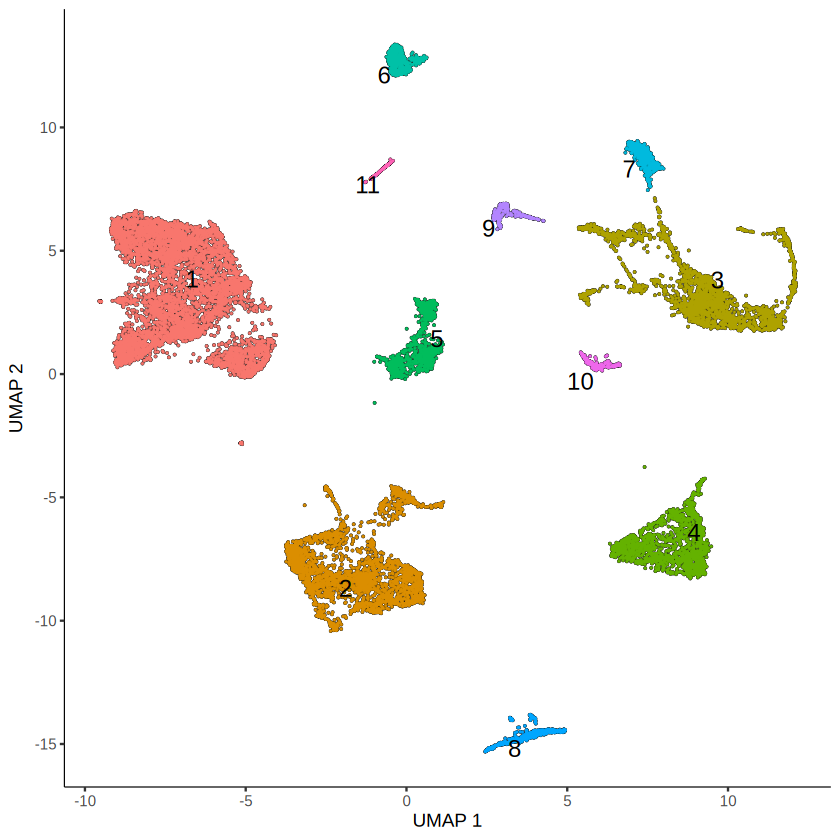

In [7]:
cds <- cluster_cells(cds, reduction_method='UMAP', cluster_method='leiden', resolution=0.00001)
plot_cells(cds, group_label_size=5)
ggsave(file.path(plot_dir, 'cells/clusters.png'))

No trajectory to plot. Has learn_graph() been called yet?

Saving 7 x 7 in image


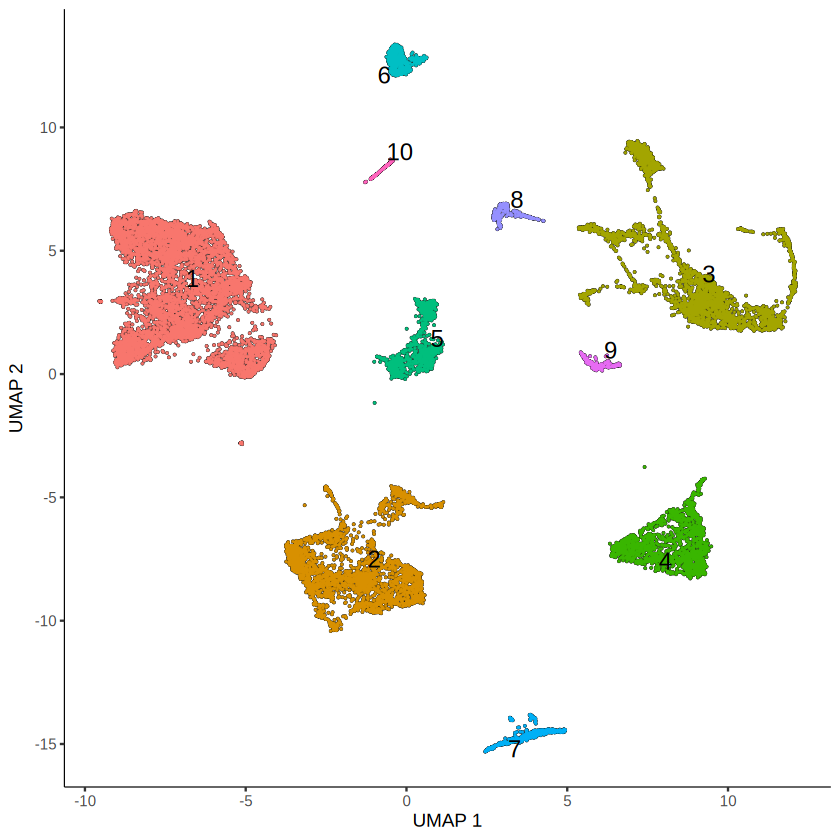

In [8]:
plot_cells(cds, color_cells_by='partition', group_cells_by='partition',
           group_label_size=5)
ggsave(file.path(plot_dir, 'cells/partitions.png'))

No trajectory to plot. Has learn_graph() been called yet?

Saving 7 x 7 in image


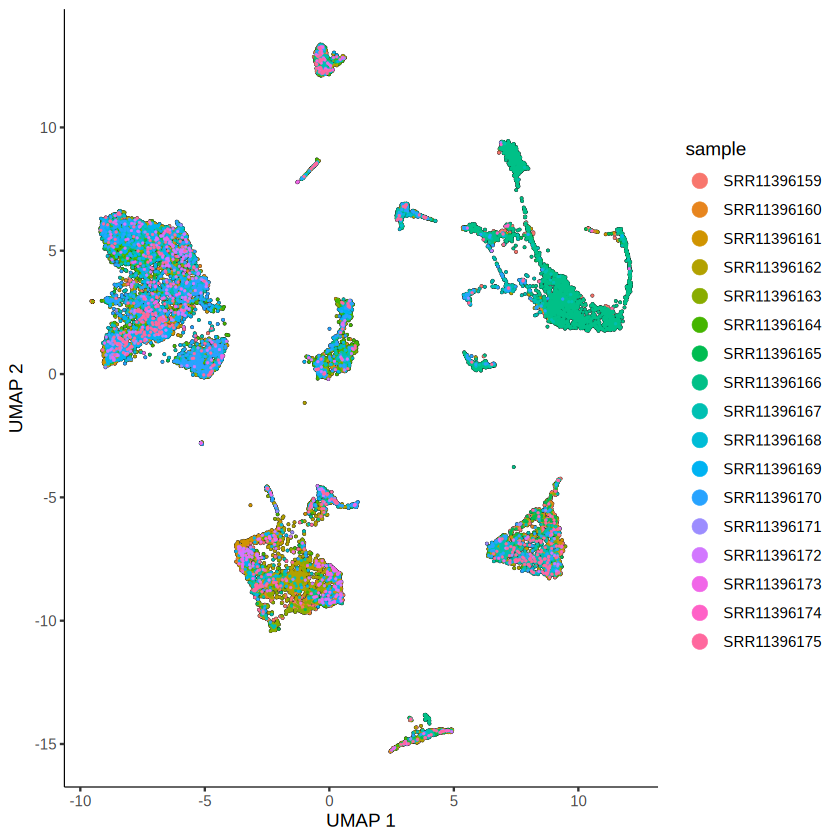

In [9]:
plot_cells(cds, color_cells_by='sample', label_cell_groups=FALSE)
ggsave(file.path(plot_dir, 'cells/samples.png'))

No trajectory to plot. Has learn_graph() been called yet?

Saving 7 x 7 in image


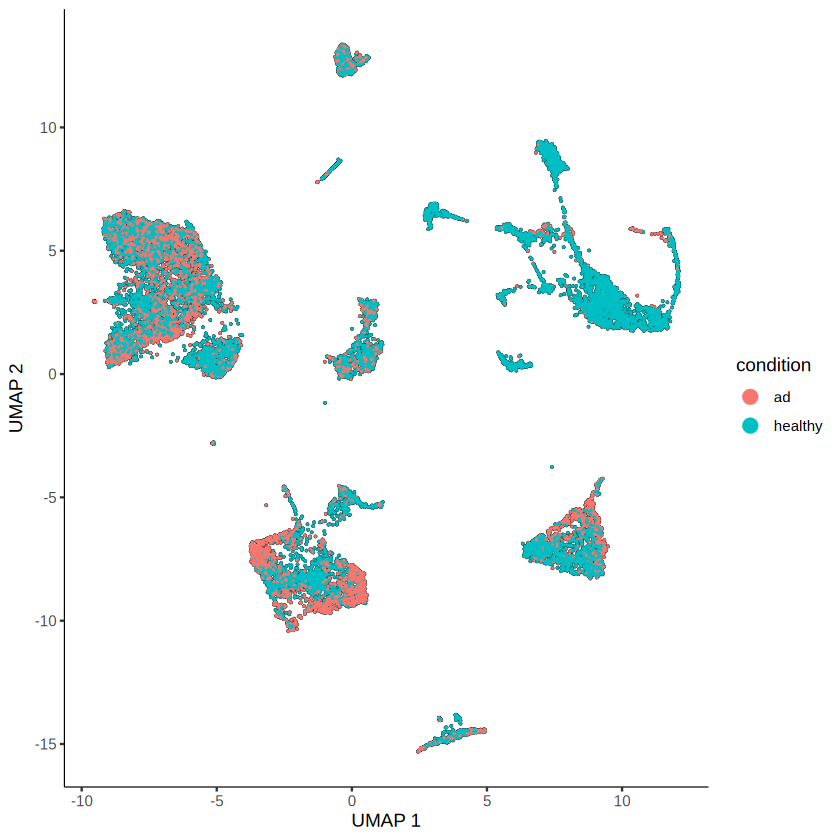

In [10]:
plot_cells(cds, color_cells_by='condition', label_cell_groups=FALSE)
ggsave(file.path(plot_dir, 'cells/conditions.png'))

# He cell typing

In [11]:
# get top marker genes per partition
markers <- top_markers(cds, group_cells_by='partition',
                       genes_to_test_per_group=100,
                       reduction_method='UMAP', cores=12)

'as(<lgCMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "dMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



  |=======================================================| 100%, Elapsed 00:02
  |=======================================================| 100%, Elapsed 01:13


In [12]:
# manually remove genes that are expressed across
# all celltypes and show up in the dot plots
#to_remove <- c('CST3', 'LGALS1', 'DBI', 'CD9')
#markers <- markers %>% filter(!(gene_id %in% to_remove))
# exclude genes starting with ENSG
markers <- markers %>%
    filter(!str_starts(gene_id, "ENSG"))
# exclude long non-coding genes
markers <- markers %>%
    filter(!str_starts(gene_id, "LINC"))
# filter for best dotplot genes
top_markers <- markers %>%
                    #filter(specificity >= 0.5) %>%
                    group_by(cell_group) %>%
                    top_n(12, pseudo_R2)
marker_ids <- unique(top_markers$gene_id)

In [13]:
out_path <- file.path(plot_dir, 'genes/partition_genes_dotplot.png')
plot <- plot_genes_by_group(cds,
                            markers=marker_ids,
                            group_cells_by='partition',
                            ordering_type='cluster_row_col',
                            max.size=3)
ggsave(out_path, plot, width=8, height=12)

In [14]:
# adding partition cell types
colData(cds)$partition_cell_type <- as.character(partitions(cds))
colData(cds)$partition_cell_type <- dplyr::recode(colData(cds)$partition_cell_type,
                                                  '1'='Vascular ECs',
                                                  '2'='Fibroblasts',
                                                  '3'='Keratinocytes 1',
                                                  '4'='T cells',
                                                  '5'='Mural cells',
                                                  '6'='Lymphatic ECs',
                                                  '7'='Myeloid cells',
                                                  '8'='Keratinocytes 2',
                                                  '9'='Keratinocytes 3',
                                                  '10'='Schwann cells')

No trajectory to plot. Has learn_graph() been called yet?



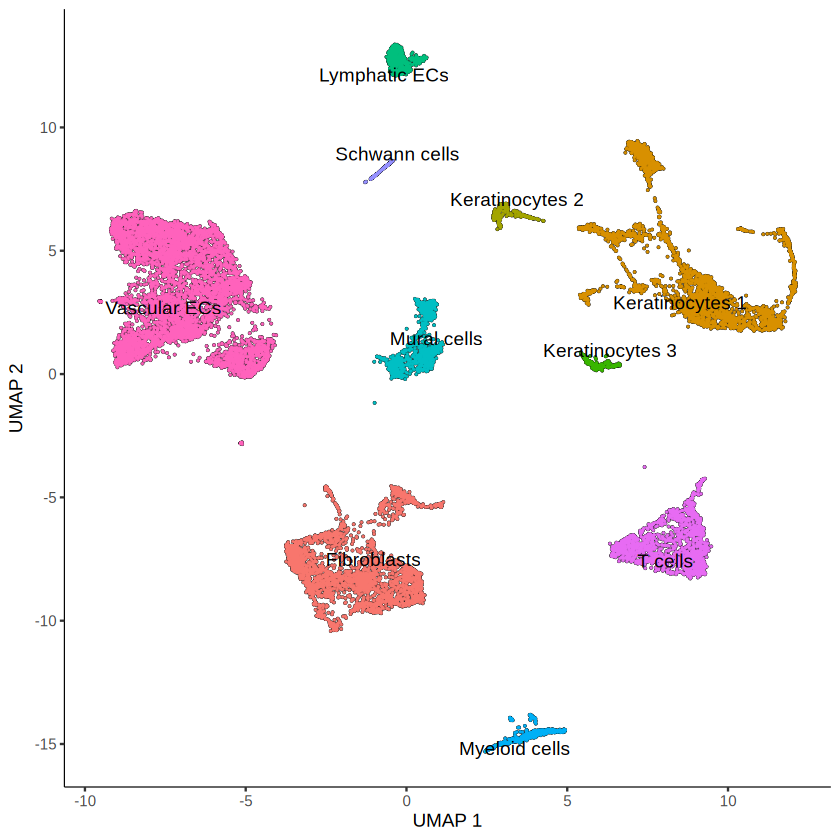

In [15]:
plot_cells(cds, color_cells_by='partition_cell_type', group_cells_by='partition',
           group_label_size=4)
ggsave(file.path(plot_dir, 'cells/cell-typed_partitions.png'), width=8, height=8)

# He fibroblast subpopulations

In [16]:
fibro_plot_dir <- file.path(plot_dir, 'cells/fibroblasts')

In [17]:
fibro <- cds[, partitions(cds) %in% c('2')]

Saving 7 x 7 in image


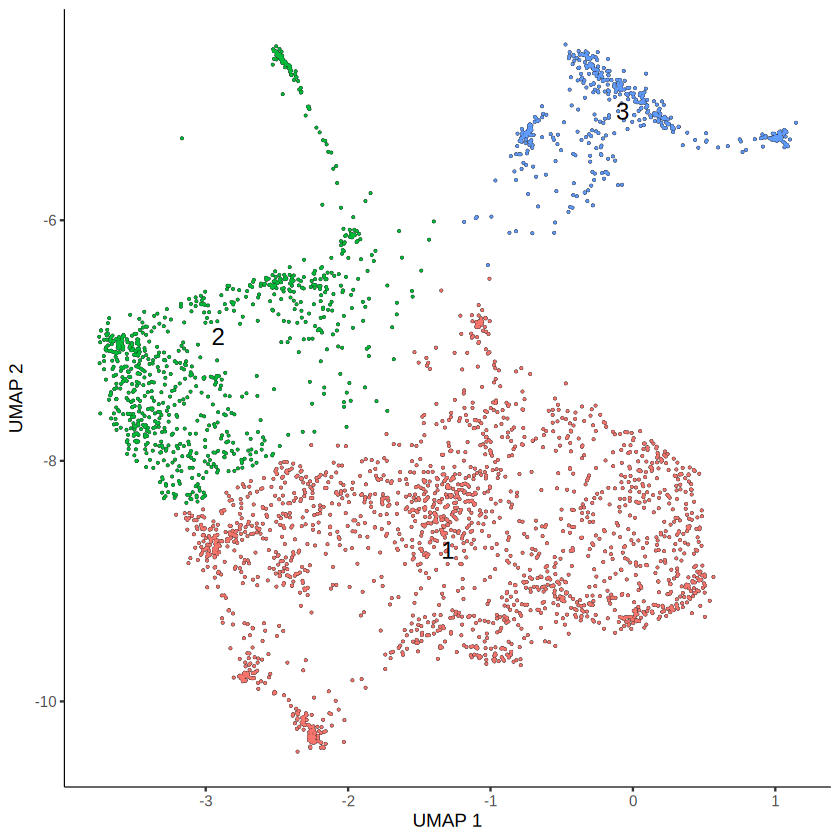

In [18]:
fibro <- cluster_cells(fibro, resolution=0.0002)
plot_cells(fibro, color_cells_by='cluster', group_label_size=5,
           show_trajectory_graph=FALSE)
ggsave(file.path(fibro_plot_dir, 'fibro_subclusters.png'))

Saving 7 x 7 in image


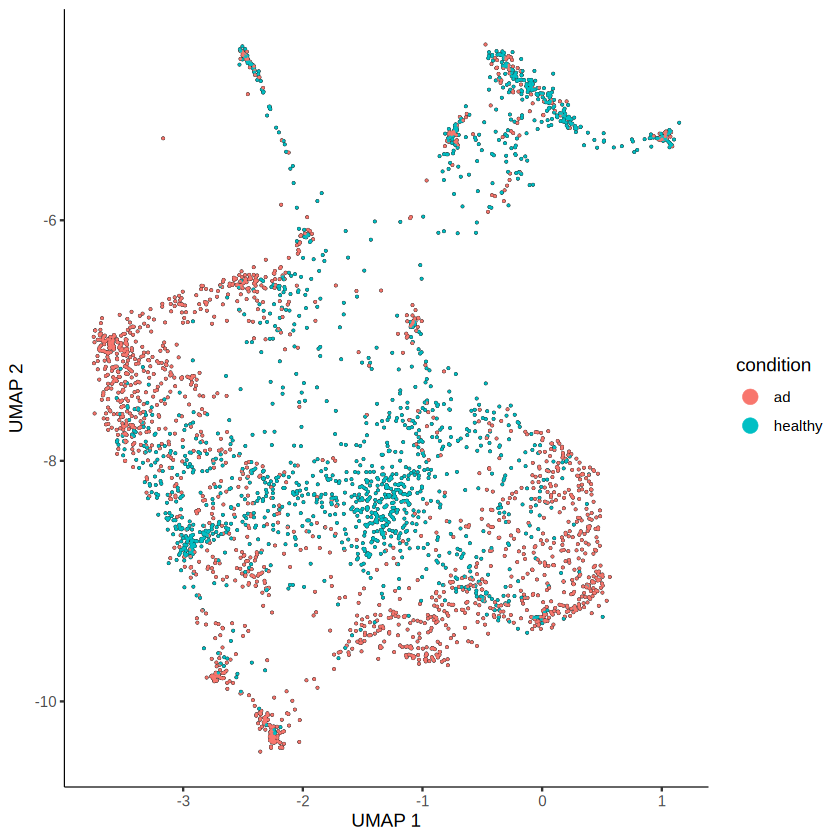

In [19]:
plot_cells(fibro, color_cells_by='condition', label_cell_groups=FALSE,
           show_trajectory_graph=FALSE)
ggsave(file.path(fibro_plot_dir, 'fibro_conditions.png'))

In [20]:
# get top marker genes per fibro cluster
markers <- top_markers(fibro, group_cells_by='cluster',
                       genes_to_test_per_group=1000, speedglm.maxiter=100,
                       reduction_method='UMAP', cores=12)

  |=======================================================| 100%, Elapsed 00:02
  |=======================================================| 100%, Elapsed 00:48


In [21]:
# exclude genes starting with ENSG
markers <- markers %>%
    filter(!str_starts(gene_id, "ENSG"))
# exclude long non-coding genes
markers <- markers %>%
    filter(!str_starts(gene_id, "LINC"))
fibro_markers <- markers %>%
                    #filter(specificity >= 0.5) %>%
                    #filter(fraction_expressing >= .9) %>%
                    group_by(cell_group) %>%
                    #top_n(16, mean_expression)
                    top_n(16, pseudo_R2)
marker_ids <- unique(fibro_markers$gene_id)

In [22]:
out_path <- file.path(fibro_plot_dir, 'fibro_genes_dotplot.png')
plot <- plot_genes_by_group(fibro,
                            markers=c(marker_ids),
                            group_cells_by='cluster',
                            ordering_type='cluster_row_col',
                            max.size=5)
ggsave(out_path, plot, width=8, height=12)

In [23]:
colData(fibro)$cluster_cell_type <- as.character(clusters(fibro))
colData(fibro)$cluster_cell_type <- dplyr::recode(colData(fibro)$cluster_cell_type,
                                                  '1'='Inflammatory fibroblasts',
                                                  '2'='Normal fibroblasts',
                                                  '3'='Pericyte-like fibroblasts')

In [24]:
# merge these fibroblast subtypes with the original cds
colData(cds)$subclustered_cell_type <- colData(cds)$partition_cell_type
colData(cds)[colnames(fibro), ]$subclustered_cell_type <- colData(fibro)$cluster_cell_type

No trajectory to plot. Has learn_graph() been called yet?



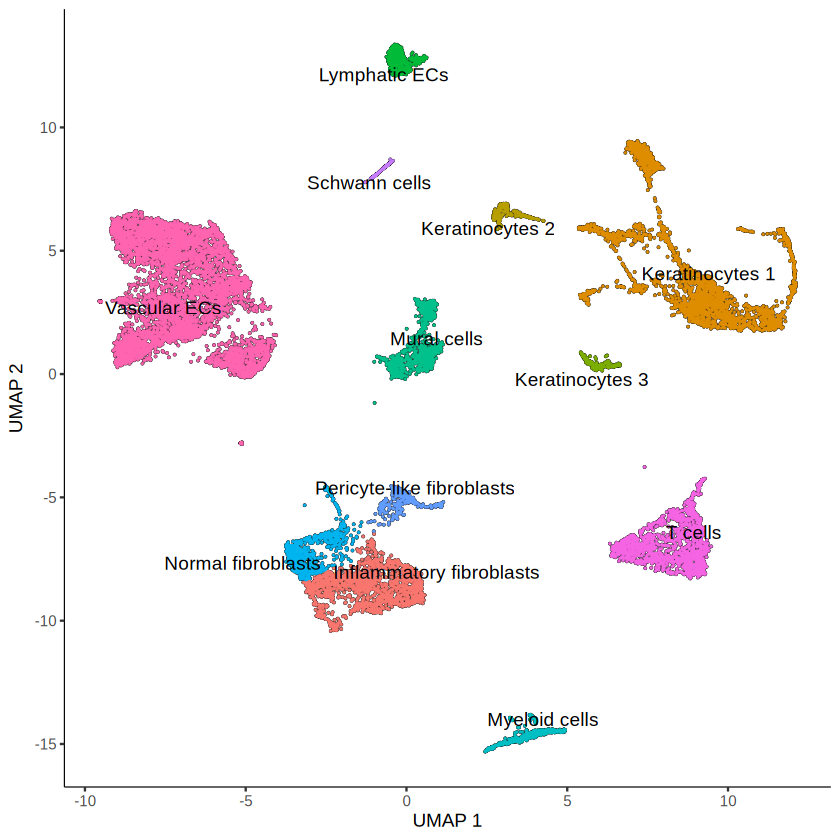

In [25]:
plot_cells(cds, color_cells_by='subclustered_cell_type', group_cells_by='partition',
           group_label_size=4,labels_per_group=4)
ggsave(file.path(plot_dir, 'cells/cell-typed_partitions.png'), width=8, height=8)

# He myeloid subpopulations

### Fibroblast cluster DEGs with Seurat

In [138]:
# convert to seurat obj
fibro_counts <- counts(fibro)
fibro_genes <- rownames(fibro)
fibro_cells <- colnames(fibro)
df <- data.frame(fibro_counts)
rownames(df) <- fibro_genes
colnames(df) <- fibro_cells
cell_meta <- colData(fibro)
cell_meta$cluster <- clusters(fibro)
cell_meta <- as.data.frame(cell_meta)
obj <- CreateSeuratObject(fibro_counts, meta.data=cell_meta)

In [139]:
# get per-cluster DEGs
obj <- NormalizeData(obj)
Idents(obj) <- obj@meta.data$cluster
degs <- FindAllMarkers(obj)

Normalizing layer: counts

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3



In [141]:
# filter, sort, and write out degs
filt_degs <- degs %>%
                filter(p_val_adj <= 0.01, abs(avg_log2FC) >= 0.5) %>%
                arrange(cluster, desc(avg_log2FC))
degs_out_path <- '/home/6j9/projects/atopic_dermatitis/data/seurat_degs/he_fibro_degs.tsv'
write.table(filt_degs, degs_out_path, quote=FALSE, sep='\t', row.names=FALSE)
# write out all DEGs for background
degs_background_out_path <- '/home/6j9/projects/atopic_dermatitis/data/seurat_degs/he_background.tsv'
writeLines(unique(filt_degs$gene), degs_background_out_path)

### Misc. fibroblast plots

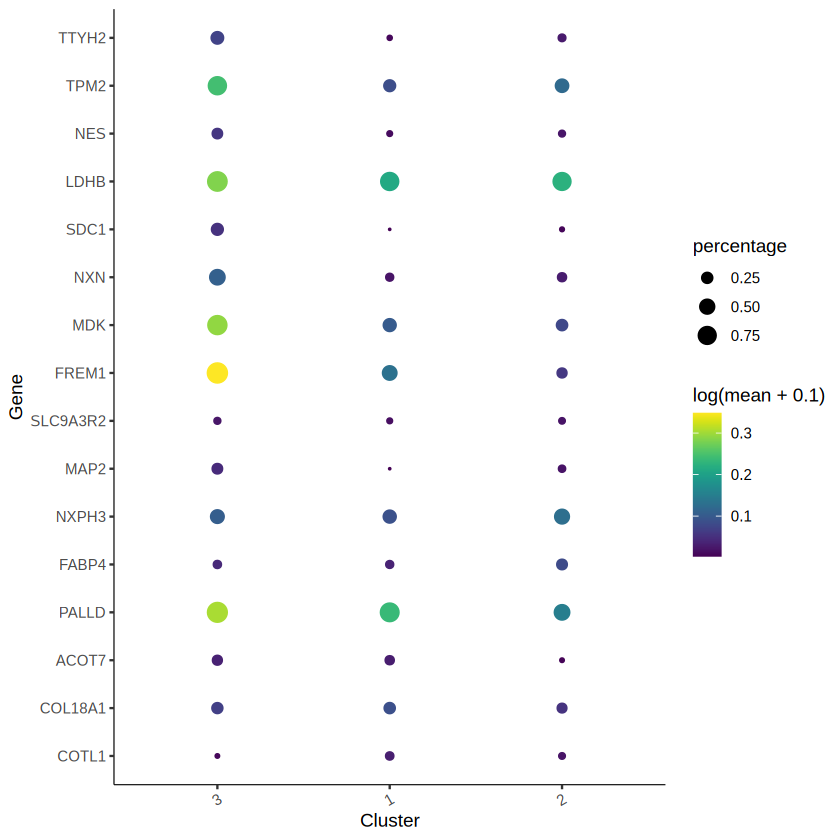

In [66]:
# looking at genes from the mouse fibroblast subclusters
fibro_genes <- c('MYOC', 'CCN5', 'VTN', 'HMCN2',
                 'FMO2', 'CXCL14', 'STEAP4', 'MGP',
                 'CILP', 'SMOC2', 'ANGPTL1', 'IGFBP3', 'GAS6')
fibro_genes <- c('PTX3', 'ACKR3', 'ANXA3', 'EFHD1', 'EBF2', 'COL6A5',
                 'COL6A6', 'AIF1L', 'BASP1', 'MRGPRG', 'LTC4S', 'DAGLB',
                 'SMPD3', 'CAR8', 'COL6A6', 'CD55')
fibro_genes <- c('NXPH3', 'NES', 'MAP2', 'SDC1', 'NXN', 'TTYH2', 'PALLD',
                 'FABP4', 'FREM1', 'ACOT7', 'TPM2', 'SLC9A3R2', 'LDHB',
                 'COL18A1', 'MDK', 'COTL1')
plot_genes_by_group(fibro,
                    markers=fibro_genes,
                    group_cells_by='cluster',
                    ordering_type='cluster_row_col',
                    max.size=5)

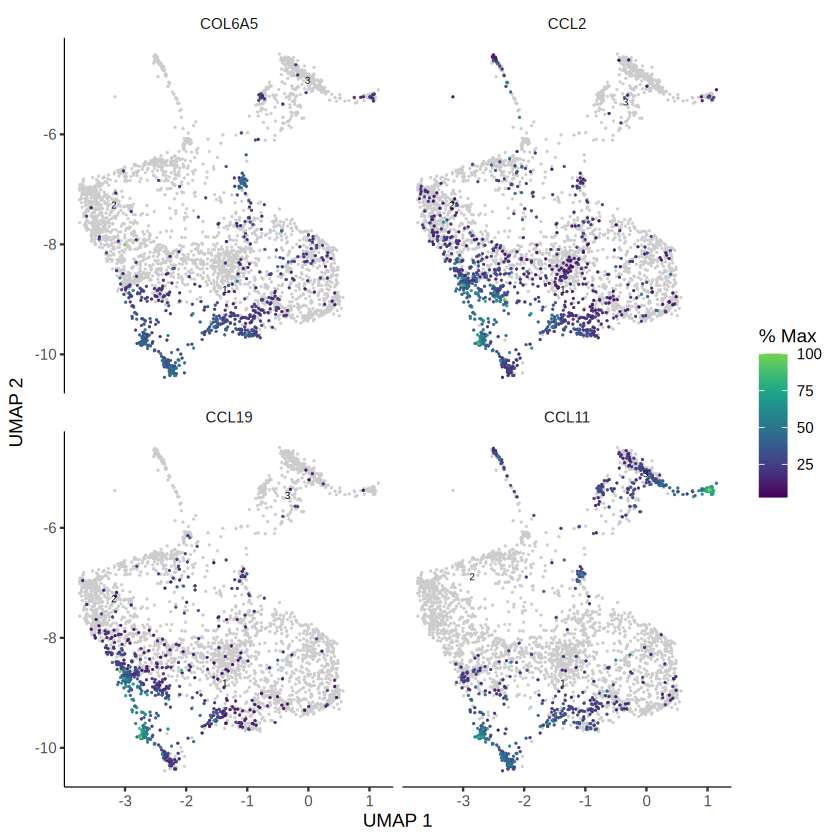

In [99]:
# cluster 1 - inflammatory fibroblasts
plot_cells(fibro, genes=c('COL6A5', 'CCL2', 'CCL19', 'CCL11'),
           show_trajectory_graph=FALSE)

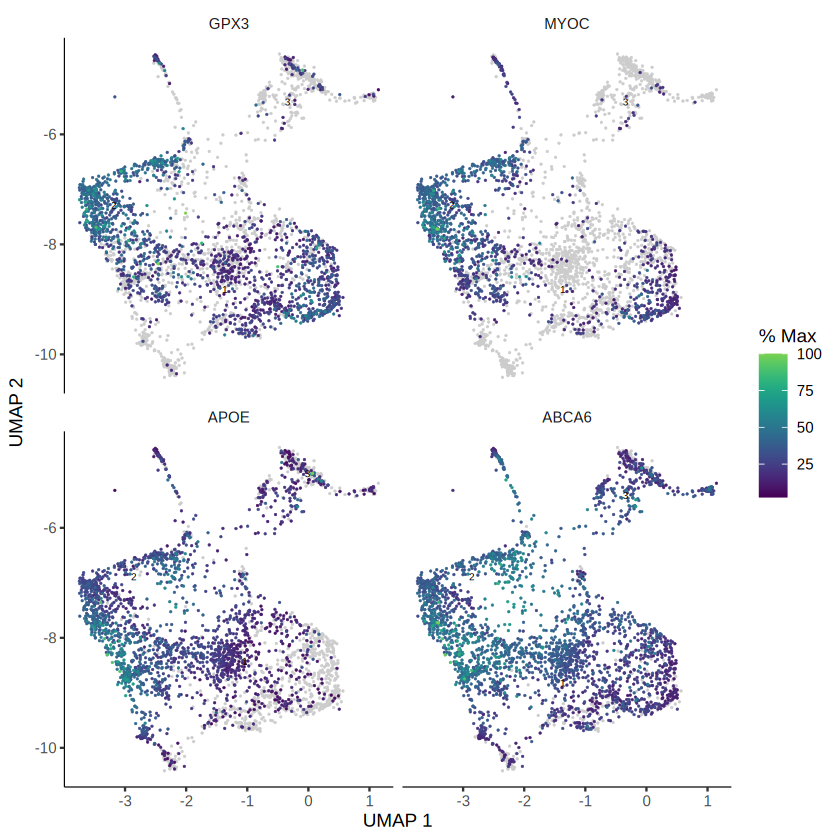

In [115]:
# cluster 2 - normal fibroblasts
plot_cells(fibro, genes=c('GPX3', 'MYOC', 'APOE', 'ABCA6'),
           show_trajectory_graph=FALSE)

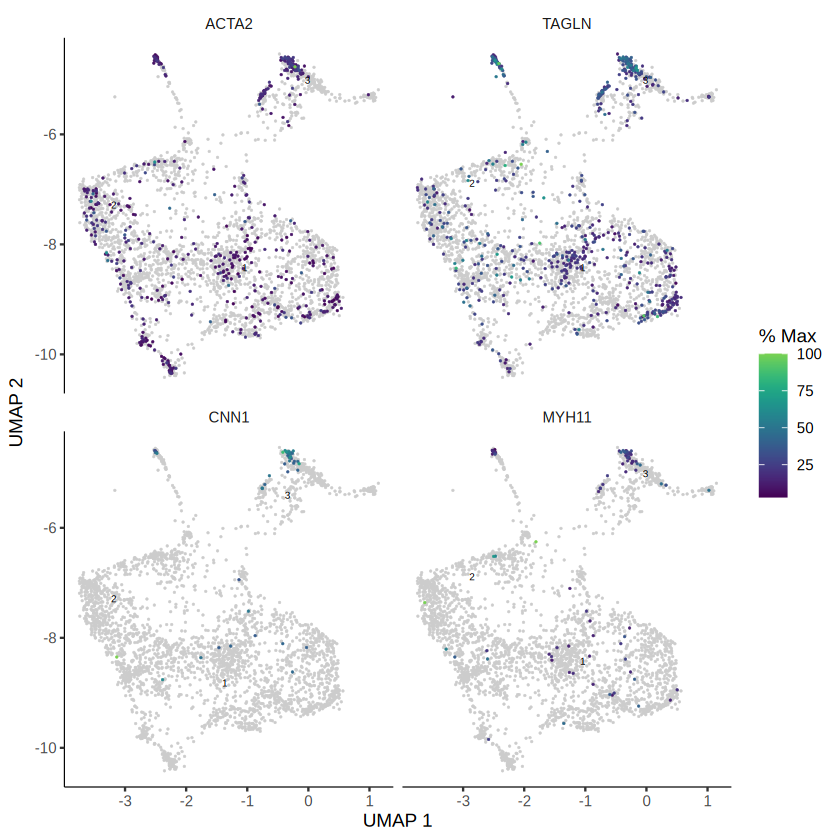

In [92]:
# cluster 3 - pericyte-like fibroblasts
plot_cells(fibro, genes=c('ACTA2', 'TAGLN', 'CNN1', 'MYH11'),
           show_trajectory_graph=FALSE)

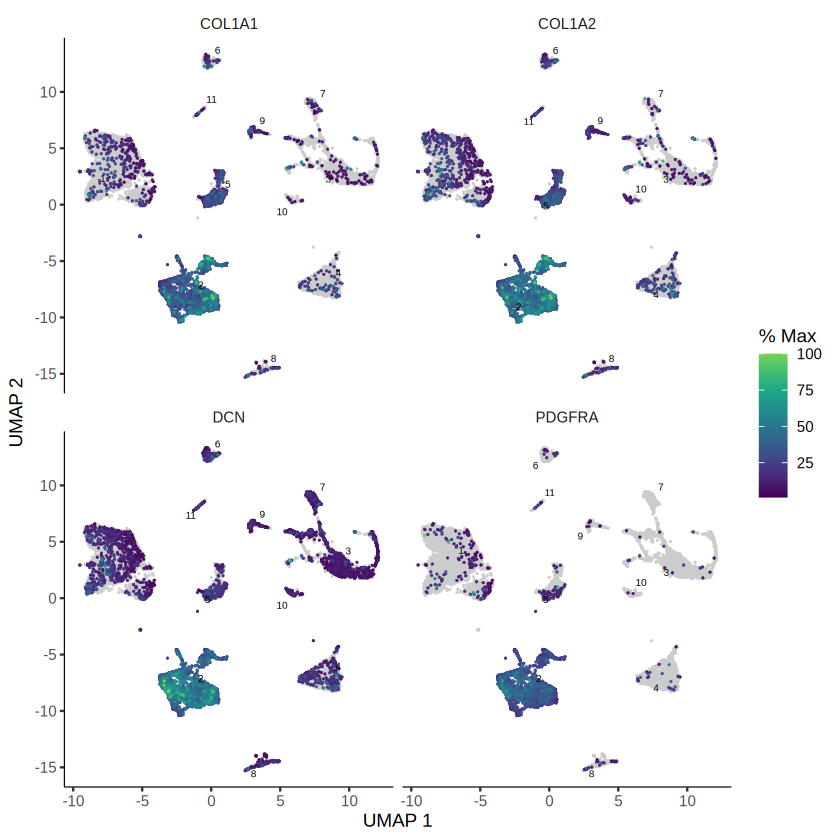

In [30]:
# pan-fibroblast markers
plot_cells(cds, genes=c('COL1A1', 'COL1A2', 'DCN', 'PDGFRA'),
           show_trajectory_graph=FALSE)

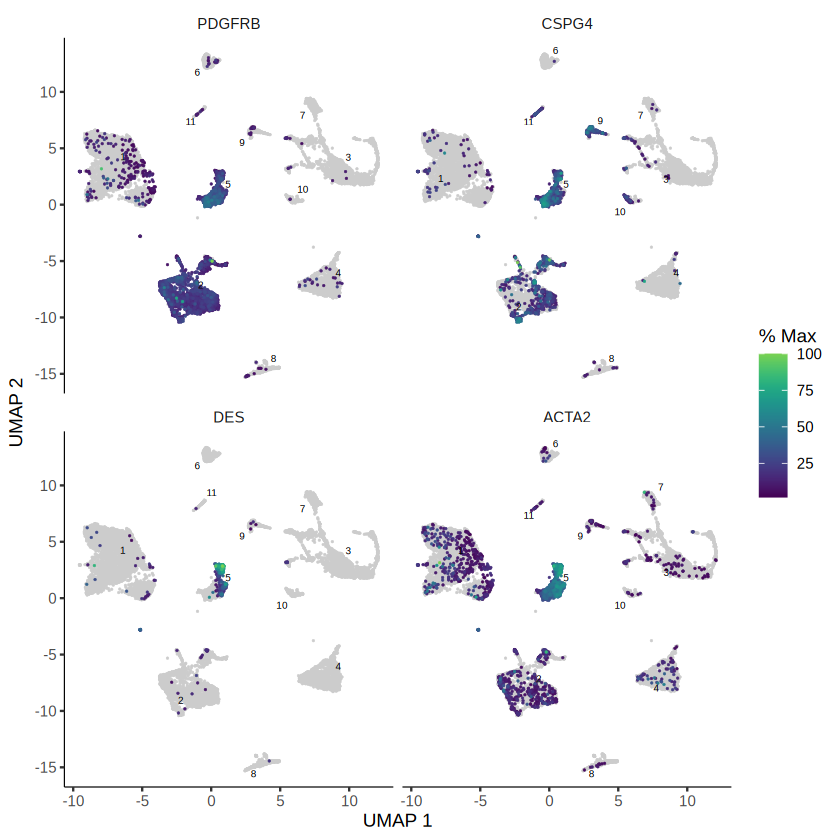

In [31]:
# pericyte markers
plot_cells(cds, genes=c('PDGFRB', 'CSPG4', 'DES', 'ACTA2'),
           show_trajectory_graph=FALSE)

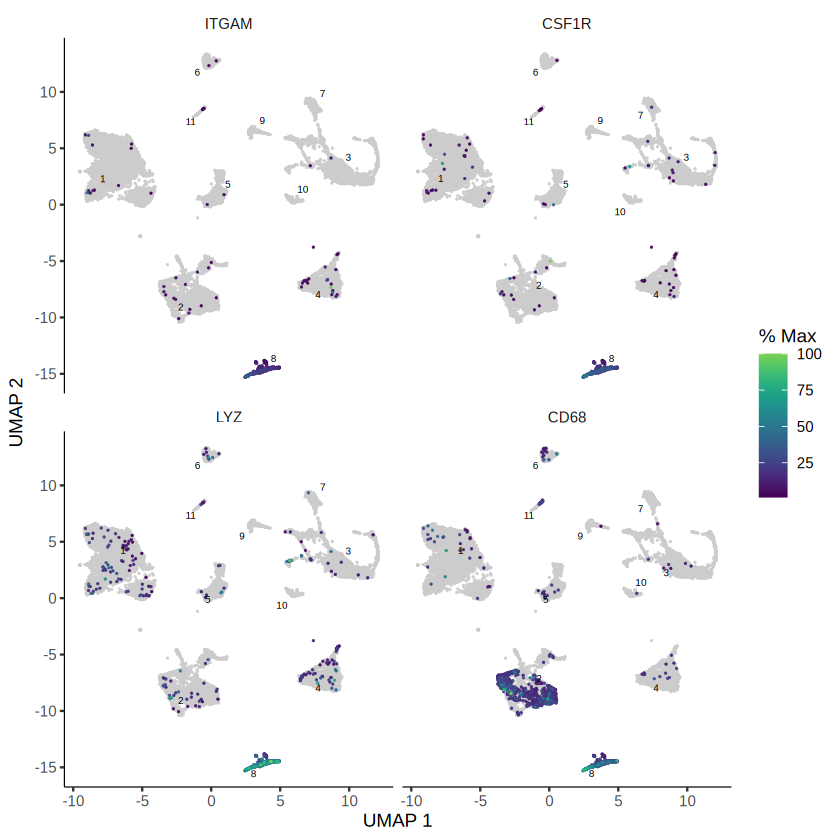

In [38]:
# myeloid markers
plot_cells(cds, genes=c('ITGAM', 'CSF1R', 'LYZ', 'CD68'),
           show_trajectory_graph=FALSE)

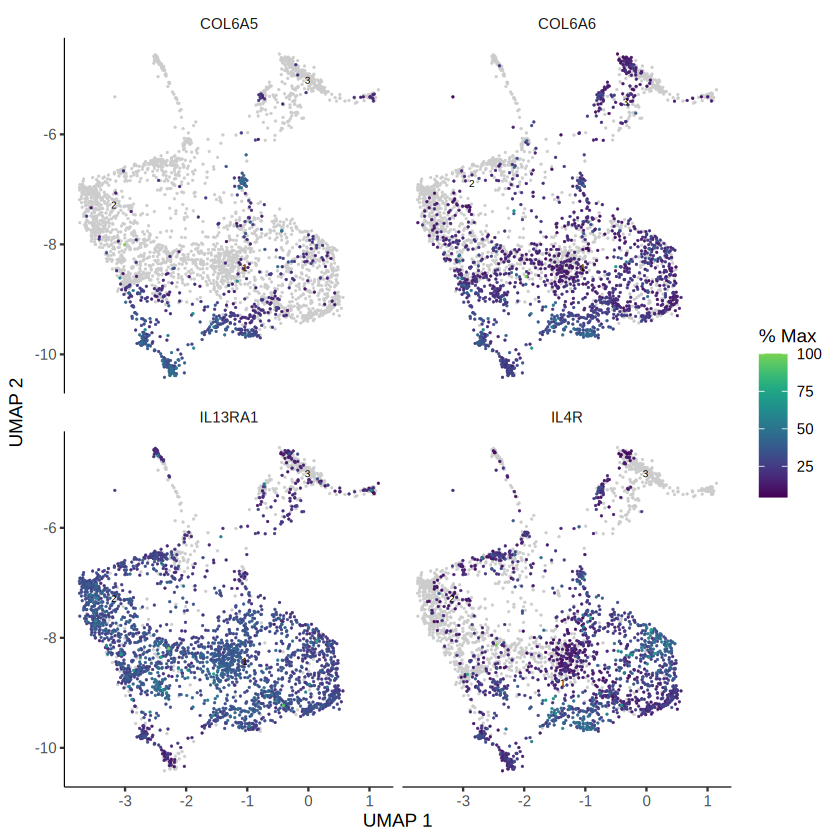

In [42]:
# inflammatory fibroblasts
plot_cells(fibro, genes=c('COL6A5', 'COL6A6', 'IL13RA1', 'IL4R'),
           show_trajectory_graph=FALSE)

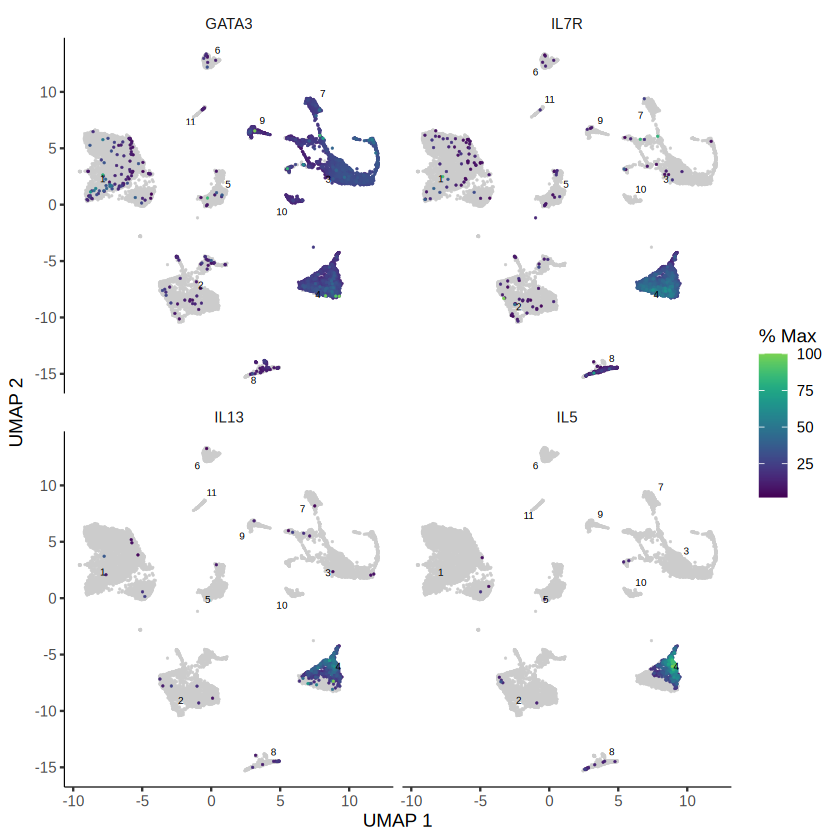

In [49]:
# Type 2 ILC2s / T cells
plot_cells(cds, genes=c('GATA3', 'IL7R', 'IL13', 'IL5'),
           show_trajectory_graph=FALSE)

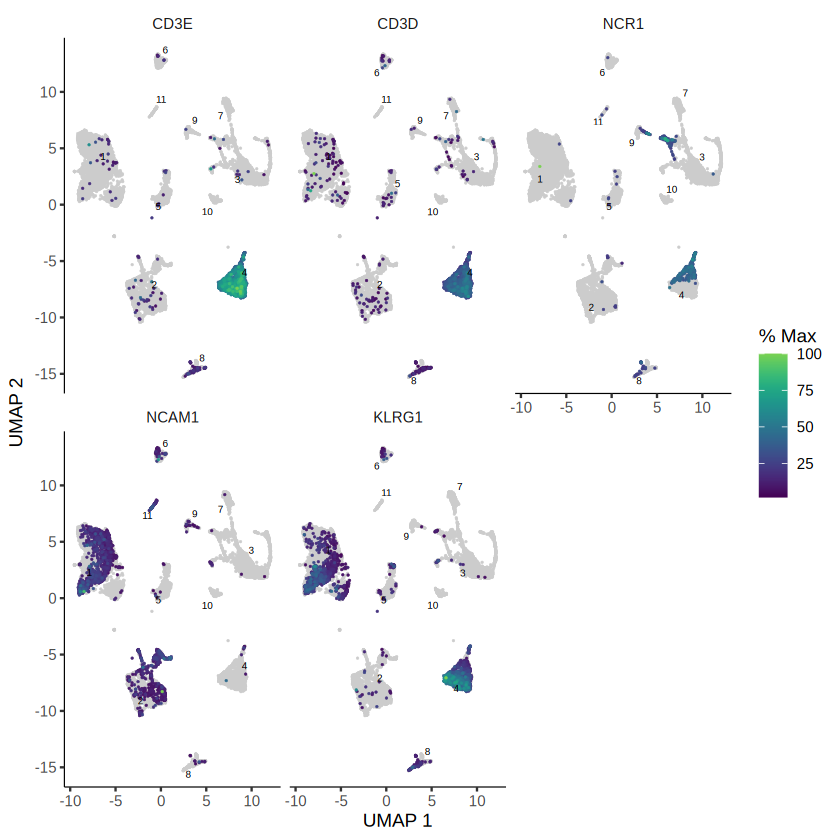

In [63]:
# T cells / NK cells
plot_cells(cds, genes=c('CD3E', 'CD3D', 'NCR1', 'NCAM1'),
           show_trajectory_graph=FALSE)

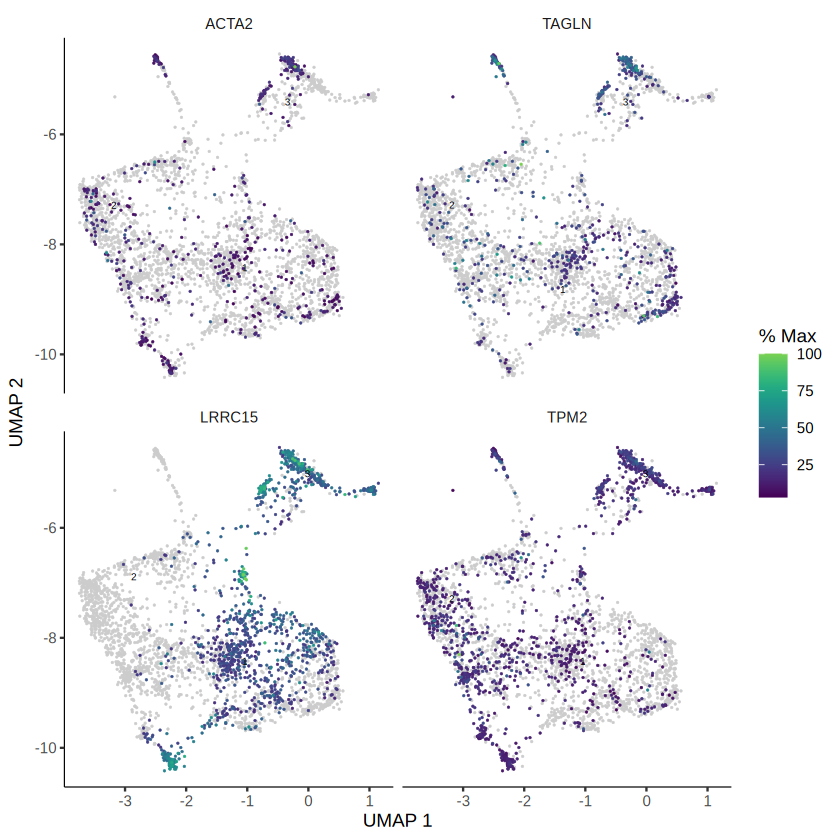

In [55]:
# pericyte-like fibroblasts
plot_cells(fibro, genes=c('ACTA2', 'TAGLN', 'LRRC15', 'TPM2'),
           show_trajectory_graph=FALSE)

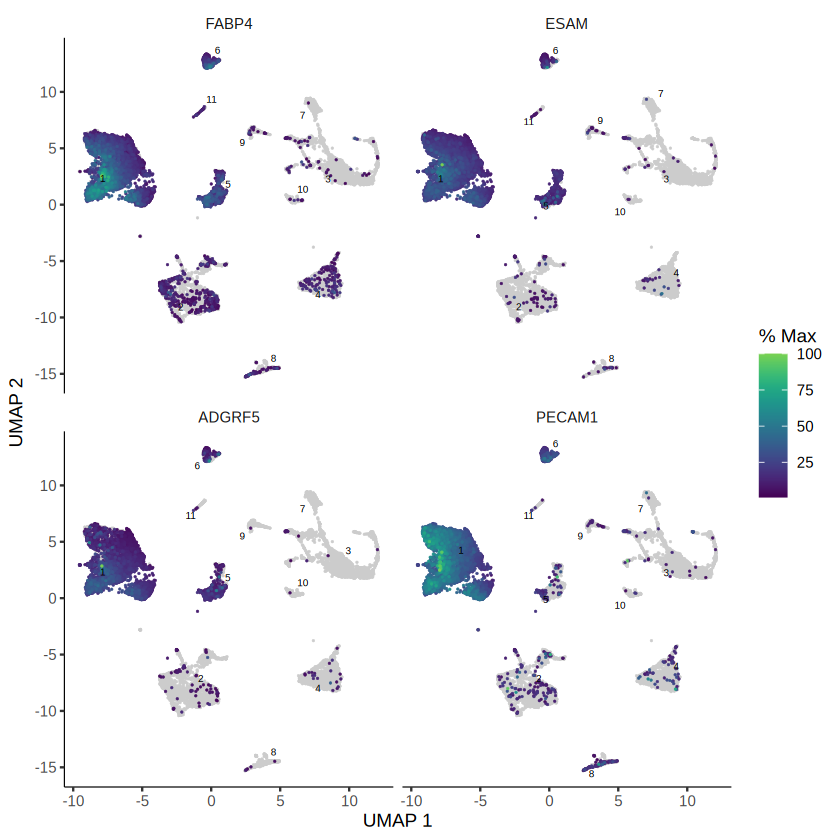

In [60]:
# ECs
plot_cells(cds, genes=c('FABP4', 'ESAM', 'ADGRF5', 'PECAM1'),
           show_trajectory_graph=FALSE)

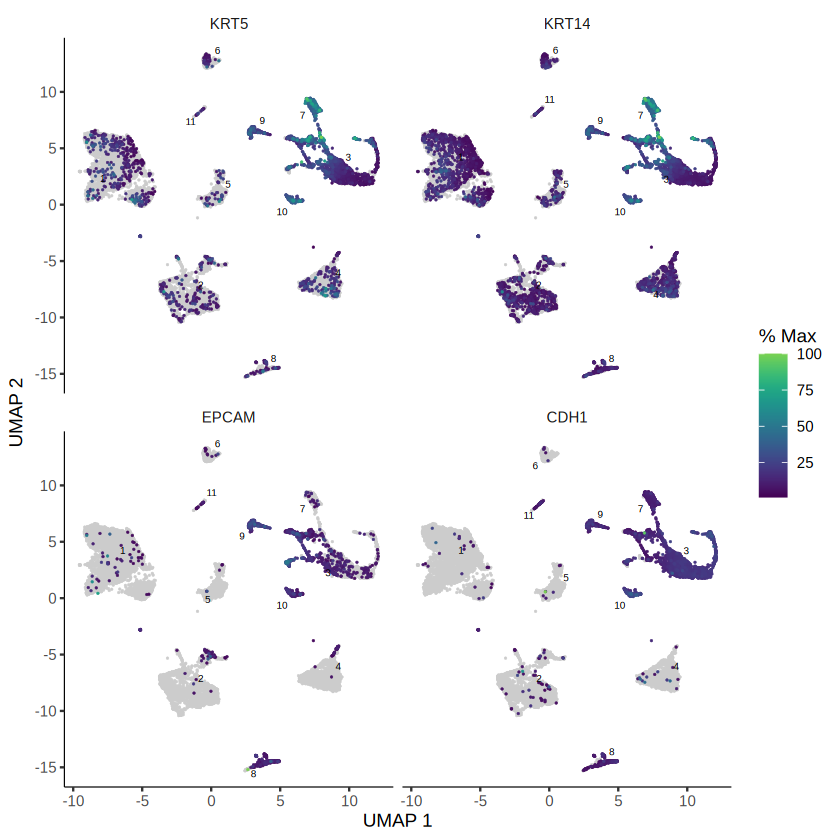

In [62]:
# Epithelial cells
plot_cells(cds, genes=c('KRT5', 'KRT14', 'EPCAM', 'CDH1'),
           show_trajectory_graph=FALSE)

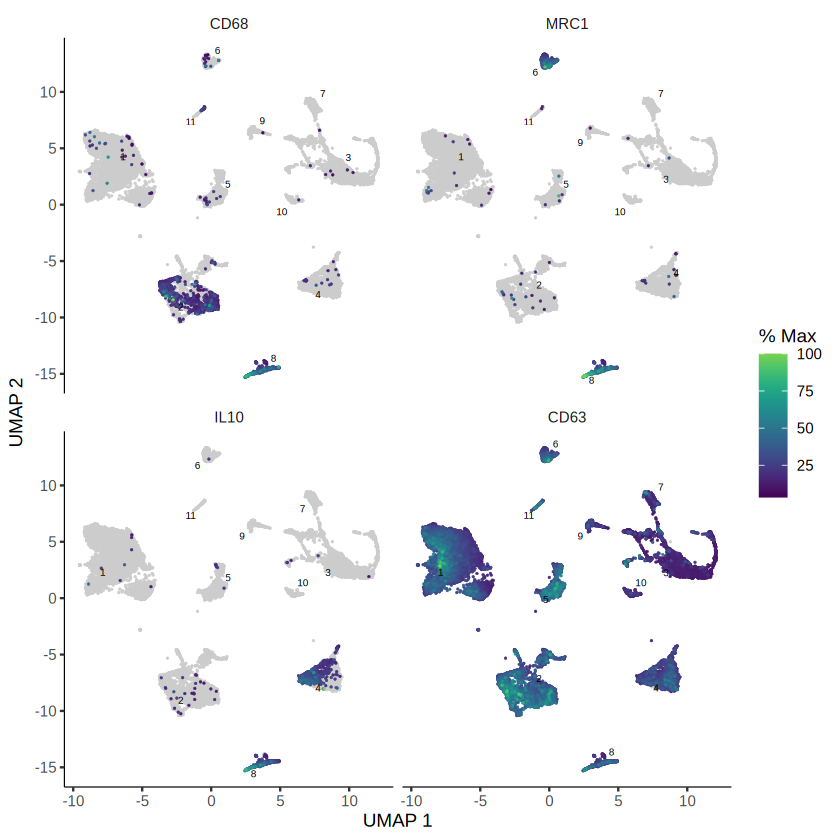

In [64]:
# M2-like macrophages
plot_cells(cds, genes=c('CD68', 'MRC1', 'IL10', 'CD63'),
           show_trajectory_graph=FALSE)

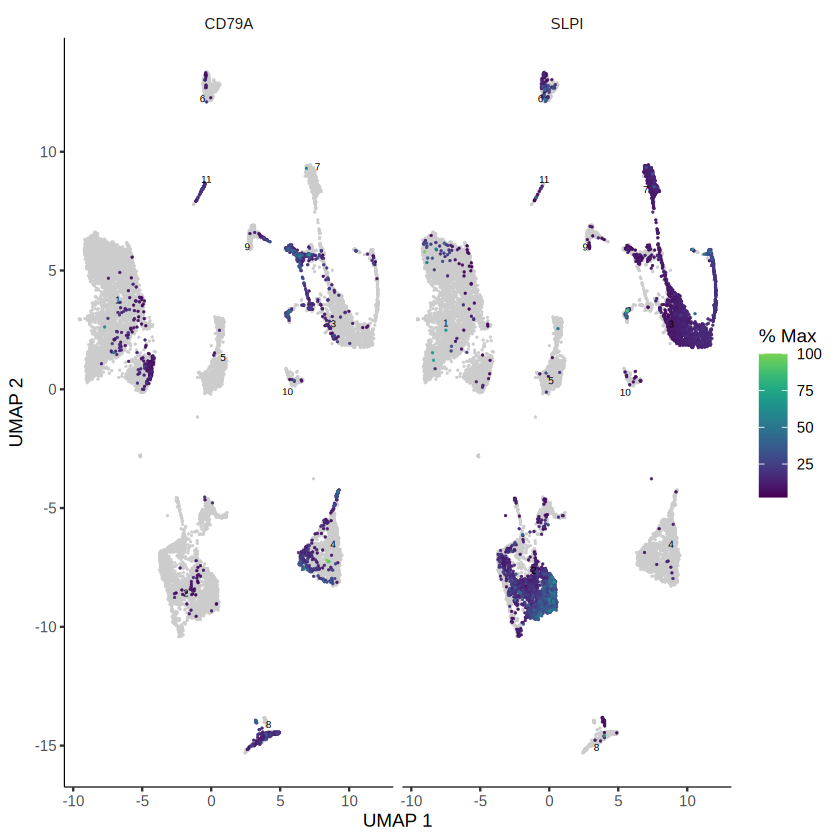

In [69]:
# B cells
plot_cells(cds, genes=c('CD79A', 'SLPI'),
           show_trajectory_graph=FALSE)

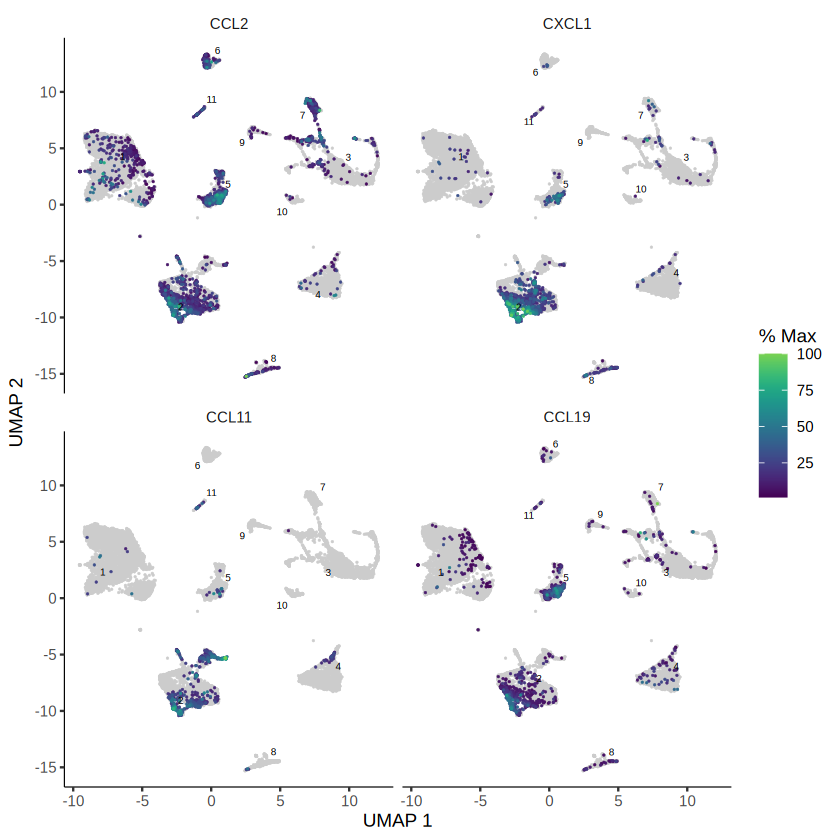

In [72]:
# chemokines
plot_cells(cds, genes=c('CCL2', 'CXCL1', 'CCL11', 'CCL19'),
           show_trajectory_graph=FALSE)

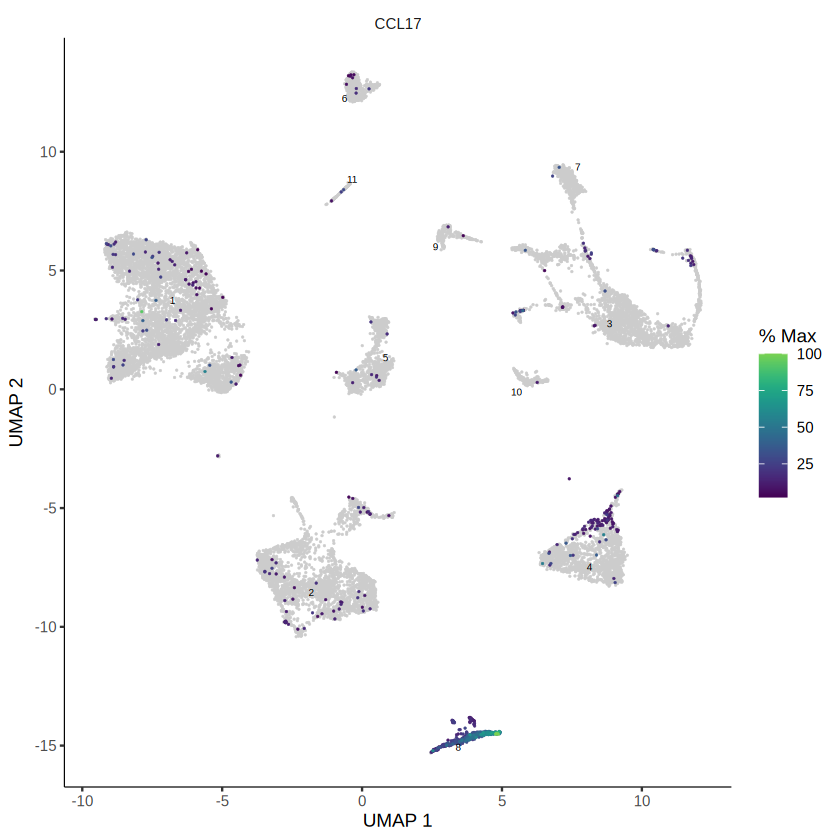

In [73]:
# more th2 genes
plot_cells(cds, genes=c('CCL17'),
           show_trajectory_graph=FALSE)

# He immune Seurat DEGs by condition

In [74]:
immune <- cds[, partitions(cds) %in% c('4', '7')]

In [75]:
# regroup immune clusters
colData(immune)$immune_cell_type <- as.character(partitions(immune))
colData(immune)$immune_cell_type <- dplyr::recode(colData(immune)$immune_cell_type,
                                                  '4'='Lymphocytes',
                                                  '7'='Phagocytes')

In [76]:
# convert to seurat obj
immune_counts <- counts(immune)
immune_genes <- rownames(immune)
immune_cells <- colnames(immune)
df <- data.frame(immune_counts)
rownames(df) <- immune_genes
colnames(df) <- immune_cells
cell_meta <- colData(immune)
cell_meta$cluster <- clusters(immune)
cell_meta <- as.data.frame(cell_meta)
obj <- CreateSeuratObject(immune_counts, meta.data=cell_meta)

In [77]:
# get phagocyte and lymphocyte by-condition DEGs
obj <- NormalizeData(obj)
Idents(obj) <- obj@meta.data$condition
phago_obj <- subset(obj, subset = immune_cell_type == "Phagocytes")
lympho_obj <- subset(obj, subset = immune_cell_type == "Lymphocytes")
phago_degs <- FindMarkers(phago_obj, ident.1='ad', ident.2='healthy')
lympho_degs <- FindMarkers(lympho_obj, ident.1='ad', ident.2='healthy')

Normalizing layer: counts

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



In [84]:
# filter, sort, and write out phago degs
filt_degs <- phago_degs %>%
                filter(p_val_adj <= 0.01, abs(avg_log2FC) >= 0.5) %>%
                arrange(desc(avg_log2FC))
filt_degs$gene <- rownames(filt_degs)
degs_out_path <- '/home/6j9/projects/atopic_dermatitis/data/seurat_degs/he_phago_degs.tsv'
write.table(filt_degs, degs_out_path, quote=FALSE, sep='\t', row.names=FALSE)
# filter, sort, and write out lympho degs
filt_degs <- lympho_degs %>%
                filter(p_val_adj <= 0.01, abs(avg_log2FC) >= 0.5) %>%
                arrange(desc(avg_log2FC))
filt_degs$gene <- rownames(filt_degs)
degs_out_path <- '/home/6j9/projects/atopic_dermatitis/data/seurat_degs/he_lympho_degs.tsv'
write.table(filt_degs, degs_out_path, quote=FALSE, sep='\t', row.names=FALSE)